In [1]:
#! pip install -r ../Uformer-RSBlur/requirements.txt

# Training

구현 한 데이터셋을 활용해 Uformer를 학습합니다. 

```bash
# ./Uformer-RSBlur
# All datasets should be located in Uformer-RSBlur/datasets
# require two of 3090, 4~5 days

# GoPro_INTER_ABME with our pipeline
python3 .train/train_RealisticGoProABMEDeblur.py --arch Uformer_B --batch_size 8 --gpu '0,1' \
--train_ps 256 --train_dir datasets/GOPRO_INTER_ABME \
--val_ps 256 --val_dir datasets/RealBlurJ_test --env _RealisticGoProABMEDeblur \
--mode deblur --nepoch 1500 --checkpoint 100 --dataset GoPro --warmup --train_workers 12

# GoPro_INTER_ABME in the naive way.
python3 train/train_NaiveGoProABMEDeblur.py --arch Uformer_B --batch_size 8 --gpu '0,1' \
--train_ps 256 --train_dir datasets/GOPRO_INTER_ABME \
--val_ps 256 --val_dir datasets/RealBlurJ_test --env _NaiveGoProABMEDeblur \
--mode deblur --nepoch 1500 --checkpoint 100 --dataset GoPro --warmup --train_workers 12

# GoPro_U with our pipeline
python3 train/train_RealisticGoProUDeblur.py --arch Uformer_B --batch_size 8 --gpu '0,1' \
--train_ps 256 --train_dir datasets/GOPRO_INTER_ABME \
--val_ps 256 --val_dir datasets/RealBlurJ_test --env _RealisticGoProUDeblur \
--mode deblur --nepoch 1500 --checkpoint 100 --dataset GoPro --warmup --train_workers 12

# GoPro_U in the naive way
python3 train/train_NaiveGoProUDeblur.py --arch Uformer_B --batch_size 8 --gpu '0,1' \
--train_ps 256 --train_dir datasets/GOPRO_INTER_ABME \
--val_ps 256 --val_dir datasets/RealBlurJ_test --env _NaiveGoProUDeblur \
--mode deblur --nepoch 1500 --checkpoint 100 --dataset GoPro --warmup --train_workers 12
```

# Test trained models

RealBlur 데이터셋에서의 평가 결과입니다. Realistic pipeline을 적용하여 1.8 db 이상의 성능 향상을 얻을 수 있습니다.

| Models | Train set | Realistic Pipeline | PSNR / SSIM    |
| :---:|:---:  |  :---:|:---:|
| Uformer-B |   GoPro |  ✓   | 30.98 / 0.9067 |
| Uformer-B |  GoPro  |     | 29.08 / 0.8754 |
| Uformer-B | GoPro_U |   ✓  | 31.19 / 0.9143 |
| Uformer-B | GoPro_U |     | 28.93 / 0.8673 |

In [2]:
import os
import sys
import math
import matplotlib.pyplot as plt

sys.path.insert(0, "../Uformer-RSBlur")
from dataset.dataset_motiondeblur import *
import utils

# 시각화 코드
def viz_two_images(img1, img2, title1, title2):
    fig = plt.figure(figsize=(16, 16))
    rows = 1; cols = 2

    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.set_title(title1)
    
    if len(img1.shape) == 2:
        image1 = ax1.imshow(img1, 'gray')
    else:
        image1 = ax1.imshow(img1)

    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.set_title(title2)
    
    if len(img2.shape) == 2:
        image2 = ax2.imshow(img2, 'gray')
    else:
        image2 = ax2.imshow(img2)
    fig.tight_layout()
    plt.show()
    

def expand2square_reflect(timg, factor=128):
    _, _, h, w = timg.size()
    X = int(math.ceil(max(h, w) / float(factor)) * factor)

    pad_w = X - w
    pad_h = X - h

    img = F.pad(timg, (pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2), 'reflect')
    mask = torch.zeros(1, 1, X, X).type_as(timg)

    mask[:, :, ((X - h) // 2):((X - h) // 2 + h), ((X - w) // 2):((X - w) // 2 + w)].fill_(1)

    return img, mask

class Args():
    
    def __init__(self):
        pass


rgb_dir_test_realblur = os.path.join('../Uformer-RSBlur/datasets', 'RealBlurJ_test', 'test', 'input')
test_dataset_realblur = get_test_data(rgb_dir_test_realblur, img_options={})

rgb_dir_test_dynamic = os.path.join('../Uformer-RSBlur/datasets', 'dynamic_scene_0310_down_subsample')
test_dataset_dynamic = get_test_data(rgb_dir_test_dynamic, img_options={})
    
opt = Args()
opt.arch = 'Uformer_B'
opt.train_ps = 256
opt.dd_in = 3

# training with our pipeline, 
weight_path = '../Uformer-RSBlur/logs/Uformer_B_RealisticGoProABMEDeblur.pth' # 30.98 PSNR
#weight_path = '../Uformer-RSBlur/logs/Uformer_B_RealisticGoProUDeblur.pth' # 31.19 PSNR
model_restoration = utils.get_arch(opt)
utils.load_checkpoint(model_restoration, weight_path)
model_restoration.cuda()
model_restoration.eval()

# naive training
weight_path = '../Uformer-RSBlur/logs/Uformer_B_NaiveGoProABMEDeblur.pth' # 29.08 PSNR
#weight_path = '../Uformer-RSBlur/logs/Uformer_B_NaiveGoProUDeblur.pth' # 28.93 PSNR
model_restoration_naive = utils.get_arch(opt)
utils.load_checkpoint(model_restoration_naive, weight_path)
model_restoration_naive.cuda()
model_restoration_naive.eval()

You choose Uformer_B...
You choose Uformer_B...


Uformer(
  embed_dim=32, token_projection=linear, token_mlp=leff,win_size=8
  (pos_drop): Dropout(p=0.0, inplace=False)
  (input_proj): InputProj(
    (proj): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (output_proj): OutputProj(
    (proj): Sequential(
      (0): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (encoderlayer_0): BasicUformerLayer(
    dim=32, input_resolution=(256, 256), depth=1
    (blocks): ModuleList(
      (0): LeWinTransformerBlock(
        dim=32, input_resolution=(256, 256), num_heads=1, win_size=8, shift_size=0, mlp_ratio=4.0,modulator=None
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (attn): WindowAttention(
          dim=32, win_size=(8, 8), num_heads=1
          (qkv): LinearProjection(
            (to_q): Linear(in_features=32, out_features=32, bias=True)
            (to_kv): Linear(in_

# Deblurring results on  RealBlur

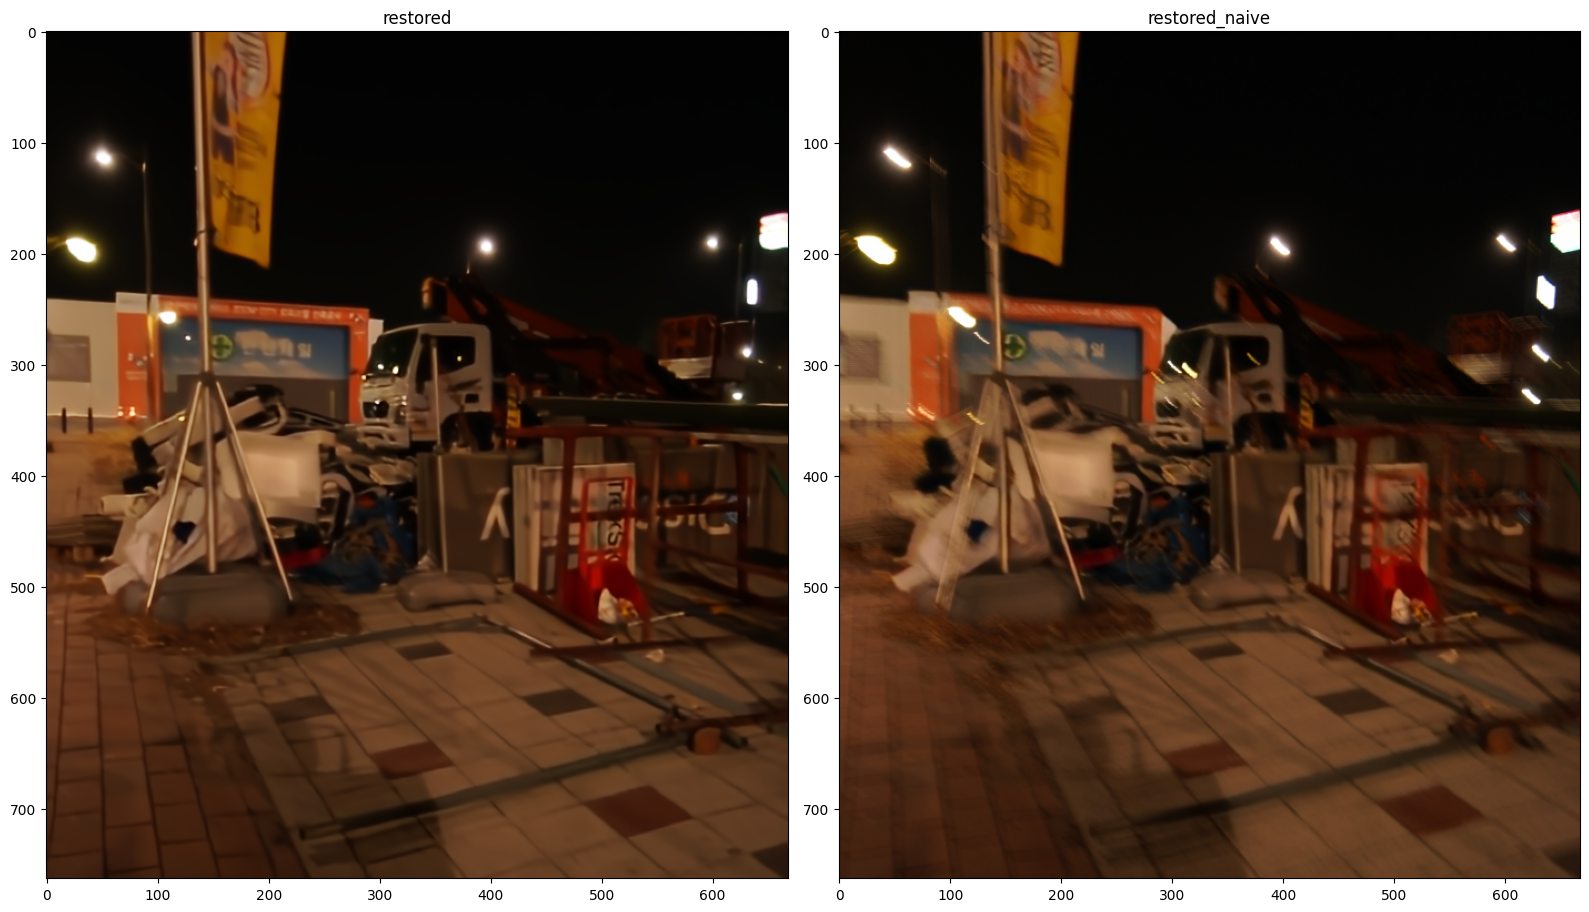

In [32]:
data_test = test_dataset_realblur[5]

with torch.no_grad():
    torch.cuda.ipc_collect()
    torch.cuda.empty_cache()

    input_    = data_test[0].cuda().unsqueeze(0)
    _, _, h, w = input_.shape
    filenames = data_test[1]

    input_, mask = expand2square_reflect(input_, factor=128)

    restored = model_restoration(input_)
    restored = torch.masked_select(restored,mask.bool()).reshape(1,3,h,w)
    restored = torch.clamp(restored,0,1).cpu().numpy().squeeze().transpose((1,2,0))
    
    restored_naive = model_restoration_naive(input_)
    restored_naive = torch.masked_select(restored_naive,mask.bool()).reshape(1,3,h,w)
    restored_naive = torch.clamp(restored_naive,0,1).cpu().numpy().squeeze().transpose((1,2,0))
    
viz_two_images(restored, restored_naive, 'restored', 'restored_naive')

# Deblurring results on Real-world dynamic scenes

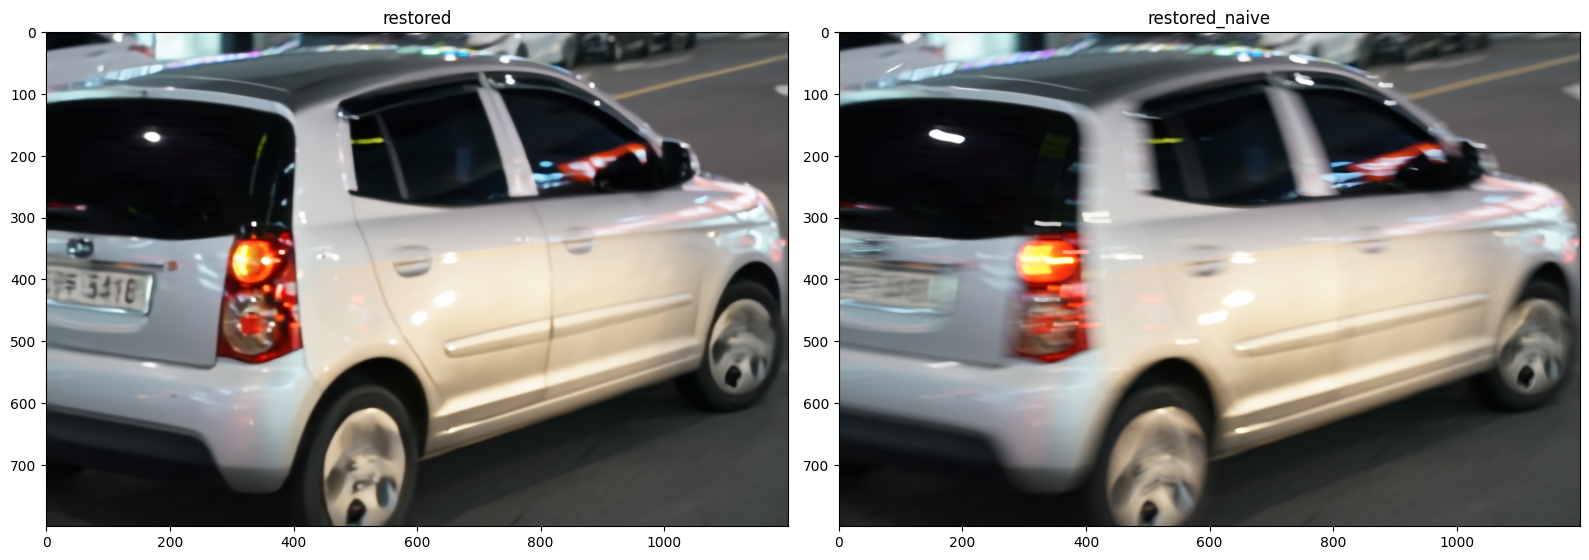

In [31]:
data_test = test_dataset_dynamic[0]

with torch.no_grad():
    torch.cuda.ipc_collect()
    torch.cuda.empty_cache()

    input_    = data_test[0].cuda().unsqueeze(0)
    _, _, h, w = input_.shape
    filenames = data_test[1]

    input_, mask = expand2square_reflect(input_, factor=128)

    restored = model_restoration(input_)
    restored = torch.masked_select(restored,mask.bool()).reshape(1,3,h,w)
    restored = torch.clamp(restored,0,1).cpu().numpy().squeeze().transpose((1,2,0))
    
    restored_naive = model_restoration_naive(input_)
    restored_naive = torch.masked_select(restored_naive,mask.bool()).reshape(1,3,h,w)
    restored_naive = torch.clamp(restored_naive,0,1).cpu().numpy().squeeze().transpose((1,2,0))
    
viz_two_images(restored, restored_naive, 'restored', 'restored_naive')